# 图像分类

- 图像分类是根据图像的语义信息对不同类别图像进行区分，是计算机视觉的核心，是物体检测、图像分割、物体跟踪、行为分析、人脸识别等其他高层次视觉任务的基础。
- 解决图像分类问题常用的卷积神经网络：LeNet, AlexNet, VGG, GoogLeNet, ResNet等。

图像分类流程示意图
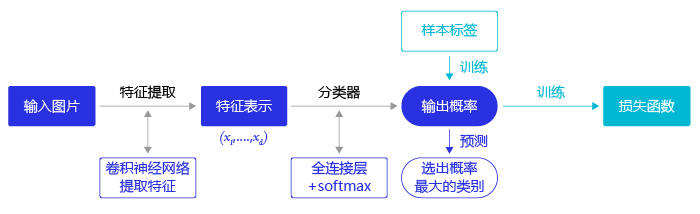

In [1]:
import paddle
from paddle.nn import Conv2D, MaxPool2D, Linear
import paddle.nn.functional as F
from paddle.vision.transforms import ToTensor
from paddle.vision.datasets import MNIST

import numpy as np
import random
import os

print('飞浆内置CV领域网络模型：', paddle.vision.models.__all__)

飞浆内置CV领域网络模型： ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext50_64x4d', 'resnext101_32x4d', 'resnext101_64x4d', 'resnext152_32x4d', 'resnext152_64x4d', 'wide_resnet50_2', 'wide_resnet101_2', 'VGG', 'vgg11', 'vgg13', 'vgg16', 'vgg19', 'MobileNetV1', 'mobilenet_v1', 'MobileNetV2', 'mobilenet_v2', 'MobileNetV3Small', 'MobileNetV3Large', 'mobilenet_v3_small', 'mobilenet_v3_large', 'LeNet', 'DenseNet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'densenet264', 'AlexNet', 'alexnet', 'InceptionV3', 'inception_v3', 'SqueezeNet', 'squeezenet1_0', 'squeezenet1_1', 'GoogLeNet', 'googlenet', 'ShuffleNetV2', 'shufflenet_v2_x0_25', 'shufflenet_v2_x0_33', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflenet_v2_x2_0', 'shufflenet_v2_swish']


## LeNet

MNIST手写数字识别任务中的LeNet-5模型网络结构示意图

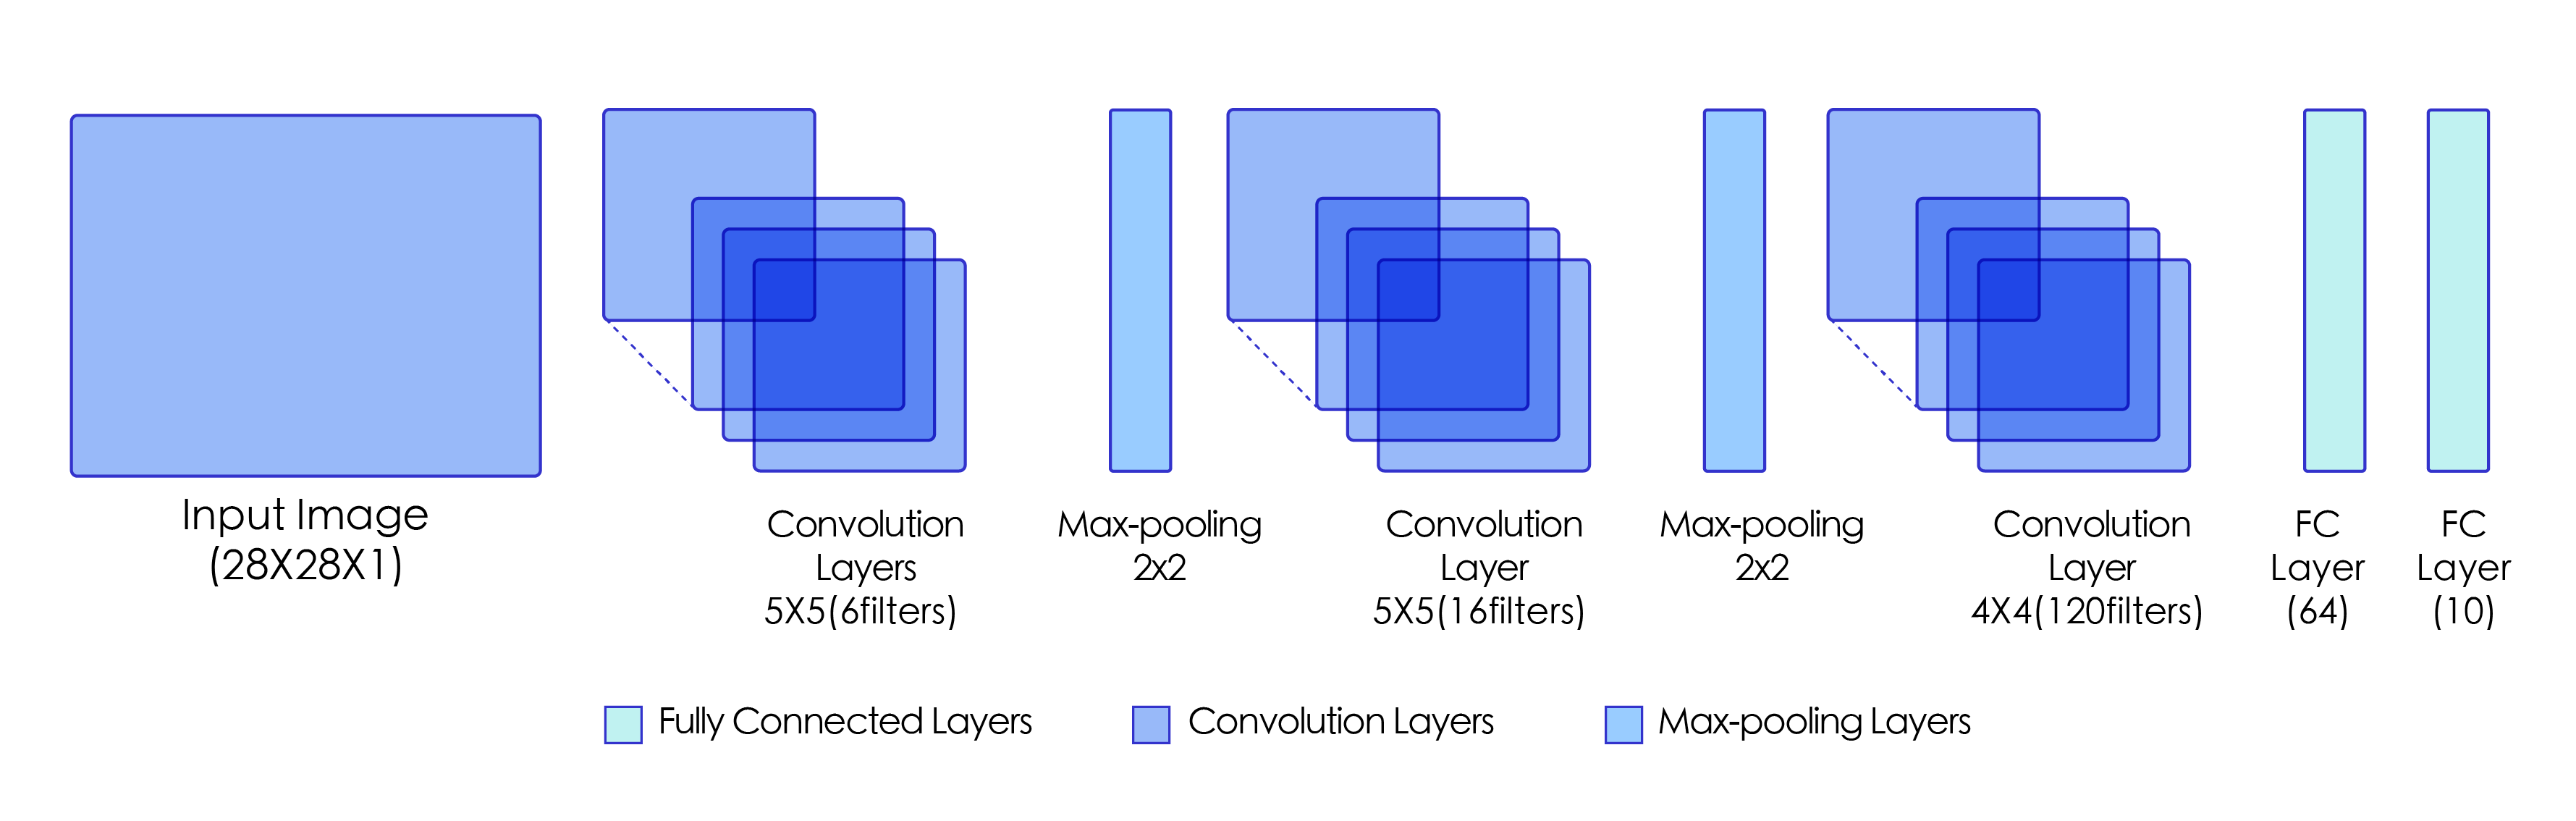

- 第一模块：包含5x5的6通道卷积和2x2的池化。
    - 卷积提取图像中的特征模式（激活函数使用Sigmoid），图像尺寸从28减小到24。
    - 经过池化层可以降低输出特征图对空间位置的敏感性，图像尺寸减小到12。
- 第二模块：和第一模块尺寸相同，通道数由6增加到16.
    - 卷积操作使图像尺寸减小到8，经过池化后变成4。
- 第三模块：包含4x4到120通道卷积。
    - 卷积之后的图像尺寸减小到1，但是通道数增加到120。
    - 将经过3次卷积提取到的特征图输入到全连接层，第一个全连接层的输出神经元个数是64，第二个全连接层的输出神经元个数是分类标签的类别数（手写数字识别任务的类别数是10）。然后使用Softmax激活函数即可计算出每个类别的预测概率。
    
    
卷积层的输出特征图如何作为全连接层的输入使用？
- 卷积层的输出数据格式是[N, C, H, W]，在输入全连接层的时候，会自动将数据拉平。
- 也就是对每个样本，自动将其转化为长度为 K = C x H x W 的向量，一个批次的数据维度变成了 N x K 的二维向量。

In [2]:
# 自定义LeNet网络结构
class LeNet(paddle.nn.Layer):
    def __init__(self, num_classes=1):
        super(LeNet, self).__init__()
        
        # 创建第一个卷积层
        self.conv1 = Conv2D(in_channels=1, out_channels=6, kernel_size=5)
        self.pool1 = MaxPool2D(kernel_size=2, stride=2)
        
        # 创建第二个卷积层
        self.conv2 = Conv2D(in_channels=6, out_channels=16, kernel_size=5)
        self.pool2 = MaxPool2D(kernel_size=2, stride=2)
        
        # 创建第三个卷积层
        self.conv3 = Conv2D(in_channels=16, out_channels=120, kernel_size=4)
        
        # 创建第一个全连接层
        # 尺寸逻辑：输入层将数据拉平 [N, C, H, W] -> [N, C*H*W]
        # 输入尺寸是[28, 28]，经过三次卷积和两次池化以后，C*H*W = 120
        self.fc1 = Linear(in_features=120, out_features=64)

        # 创建第二个全连接层
        # 第一个全连接层的输出神经元个数是64，第二个全连接层的输出神经元个数为分类标签的类别数
        self.fc2 = Linear(in_features=64, out_features=num_classes)
        
    
    # 前向计算
    def forward(self, x):
        x = self.conv1(x)
        x = F.sigmoid(x)  # 使用Sigmoid激活函数
        x = self.pool1(x)
        x = F.sigmoid(x)
        
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        
        # 输入层将数据拉平：[N, C, H, W] -> [N, C*H*W]
        x = paddle.reshape(x, [x.shape[0], -1])
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        
        return x

In [3]:
# 飞浆会根据实际图像数据的尺寸和卷积核参数自动推断中间层数据的W和H等，只需要表达数据通道即可。

# 查看网络结构
lenet = LeNet(num_classes=10)
paddle.summary(lenet, (1, 1, 28, 28))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-1       [[1, 1, 28, 28]]      [1, 6, 24, 24]          156      
  MaxPool2D-1     [[1, 6, 24, 24]]      [1, 6, 12, 12]           0       
   Conv2D-2       [[1, 6, 12, 12]]      [1, 16, 8, 8]          2,416     
  MaxPool2D-2     [[1, 16, 8, 8]]       [1, 16, 4, 4]            0       
   Conv2D-3       [[1, 16, 4, 4]]       [1, 120, 1, 1]        30,840     
   Linear-1          [[1, 120]]            [1, 64]             7,744     
   Linear-2          [[1, 64]]             [1, 10]              650      
Total params: 41,806
Trainable params: 41,806
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.16
Estimated Total Size (MB): 0.21
-----------------------------------------------------------------------

{'total_params': 41806, 'trainable_params': 41806}

In [5]:
# 使用高层API直接调用LeNet模型
lenet2 = paddle.vision.models.LeNet(num_classes=10)

# 查看网络结构
paddle.summary(lenet2, (1, 1, 28, 28))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-6       [[1, 1, 28, 28]]      [1, 6, 28, 28]          60       
    ReLU-3        [[1, 6, 28, 28]]      [1, 6, 28, 28]           0       
  MaxPool2D-5     [[1, 6, 28, 28]]      [1, 6, 14, 14]           0       
   Conv2D-7       [[1, 6, 14, 14]]     [1, 16, 10, 10]         2,416     
    ReLU-4       [[1, 16, 10, 10]]     [1, 16, 10, 10]           0       
  MaxPool2D-6    [[1, 16, 10, 10]]      [1, 16, 5, 5]            0       
   Linear-6          [[1, 400]]            [1, 120]           48,120     
   Linear-7          [[1, 120]]            [1, 84]            10,164     
   Linear-8          [[1, 84]]             [1, 10]              850      
Total params: 61,610
Trainable params: 61,610
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward

{'total_params': 61610, 'trainable_params': 61610}